In [1]:
import torch
print(torch.version.cuda)
print(torch.cuda.is_available())


11.7
True


In [ ]:
# Create a MPS device
# device = torch.device("mps")
# device

In [2]:
use_cuda=torch.cuda.is_available()
device=torch.device('cuda:0' if use_cuda else 'cpu')

In [ ]:
! pip install SentencePiece


In [ ]:
! pip install langid

In [ ]:
! pip install unidecode

In [ ]:
! pip install transformers


In [ ]:
! pip install pandas

In [ ]:
! pip install -U matplotlib

In [ ]:
! pip install wandb

In [3]:
! wandb login 0cf8d63ac20cff538d748e7412a8d60561ff1268

wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\priya/.netrc


In [4]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader,random_split,RandomSampler, SequentialSampler
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup,GPT2Config
import pandas as pd
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt
from IPython import display
plt.rcParams["figure.figsize"] = 8, 6
import wandb
import re
from collections import Counter

import unidecode
import langid
import random

In [5]:
full_dataset =pd.read_csv('../dataset/all_quotes.csv',low_memory=False)
# full_dataset=full_dataset.head(1000) #For testing purpose only
print(full_dataset.shape)


(30000, 5)


In [6]:
full_dataset.head()

,Unnamed: 0,quotes,author,tag,other_tags
0,0,“Control of consciousness determines the quali...,"― Mihaly Csikszentmihalyi, Flow: The Psycholog...",happiness,"[' consciousness, happiness, quality-of-life']"
1,1,“Copulation is no more foul to me than death is.”,"― Walt Whitman, Leaves of Grass: The First (18...",death,"[' death, sex']"
2,2,“Hope is a dream of which we long to have. Don...,"― Peace Gypsy, Souls Deep",happiness,"[' dreamers, dreams, happiness, love, peace']"
3,3,“True devotion and humility is when you carele...,― Michael Bassey Johnson,truth,"[' acceptance, achilles-heel, admiration, affe..."
4,4,"“Truths are written, never said... Lines are d...","― Colleen Hoover, Maybe Someday",poetry,"[' love, maybe-someday, poetry, ridge-lawson']"


In [7]:
#TODO
new_dataset = full_dataset[['quotes', 'tag']]
new_dataset = new_dataset[new_dataset['quotes'].apply(lambda x: unidecode.unidecode(x).isascii())]

# Set the seed for reproducibility
random.seed(123)

# Define a function to detect the language of a string
def detect_language(text):
    return langid.classify(text)[0]

# Add a new column to the DataFrame with the language of each quote
new_dataset['language'] = new_dataset['quotes'].apply(detect_language)

# Filter the DataFrame to keep only the rows where the language is English
new_dataset = new_dataset[new_dataset['language'] == 'en']

# Drop the language column from the DataFrame
new_dataset = new_dataset.drop('language', axis=1)
new_dataset = new_dataset.reset_index(drop=True)
new_dataset

,quotes,tag
0,“Control of consciousness determines the quali...,happiness
1,“Copulation is no more foul to me than death is.”,death
2,“Hope is a dream of which we long to have. Don...,happiness
3,“True devotion and humility is when you carele...,truth
4,"“Truths are written, never said... Lines are d...",poetry
...,...,...
28694,“One to be a murderer. One to be a Martyr. One...,death
28695,"“To be, or not to be: that is the question:",death
28696,“I always think of each night as a song. Or ea...,love
28697,“It's not what I'd want for at my funeral. Whe...,death


In [8]:
new_dataset.shape

(28699, 2)

           tag  count
2        truth   2926
6         love   2919
8      success   2917
0    happiness   2916
1        death   2905
9         time   2879
7      science   2867
5      romance   2842
4  inspiration   2774
3       poetry   2754


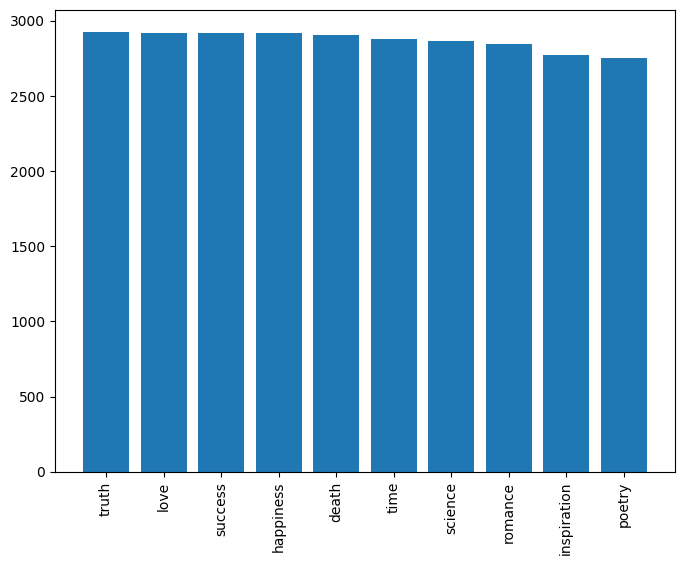

In [9]:
# Lowercase the text
# full_dataset['tags'] = full_dataset['tags'].apply(lambda x: x.lower())
tag_string = ','.join(new_dataset['tag'])
tag_list = [tag.strip() for tag in tag_string.split(',')] # all tags in this list
tag_counts = Counter(tag_list)
tag_df = pd.DataFrame({'tag': tag_counts.keys(), 'count': tag_counts.values()})
tag_df = tag_df.sort_values(by='count', ascending=False)
print(tag_df)
plt.bar(tag_df['tag'][:50], tag_df['count'][:50])
plt.xticks(rotation=90)
plt.show()

In [10]:
new_dataset['quotes'] = new_dataset['quotes'].str.replace('“', '')

In [11]:
#Data preprocessing
# Remove new line
new_dataset['quotes'] = new_dataset['quotes'].apply(lambda x: re.sub(r'\n+', ' ', x))

# Lowercase the text
new_dataset['quotes'] = new_dataset['quotes'].apply(lambda x: x.lower())

In [ ]:
#Show the word distribution as bar chart so that we can get an idea of how the sentence is distributed.

In [12]:
print(new_dataset.shape)

(28699, 2)


In [13]:
#TODO get the maximum sentence length
max_length_value=768

In [14]:
class QuotesDataset(Dataset):
    def __init__(self, quotes, tokenizer,max_length_value):
        self.input_ids = []
        self.attn_masks = []
        self.tokenizer = tokenizer

        for quote in quotes:
          encodings_dict = tokenizer("<|startoftext|>"+quote+"<|endoftext|>",
                                    truncation=True,
                                    max_length=max_length_value,
                                    padding="max_length") #We are using max length padding
          
          self.input_ids.append(torch.tensor(encodings_dict["input_ids"]))
          self.attn_masks.append(torch.tensor(encodings_dict["attention_mask"]))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.attn_masks[idx]

In [15]:
#Hyper parameters
batch_size = 5
num_epochs=10
lr=2e-5
warmup_steps=100
optimizer='Adagrad'

In [16]:
quotes = new_dataset['quotes']
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', 
                                          bos_token='<|startoftext|>', 
                                          eos_token='<|endoftext|>', 
                                          pad_token='<|pad|>')

final_dataset = QuotesDataset(quotes, tokenizer,max_length_value)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [17]:
train_size = int(0.8*len(final_dataset))
val_size = len(final_dataset) - train_size
print(train_size,val_size)
train_dataset, val_dataset = random_split(final_dataset, [train_size, val_size])
train_dataloader = DataLoader(train_dataset,
                              sampler=RandomSampler(train_dataset),
                              batch_size=batch_size)

val_dataloader = DataLoader(val_dataset,
                            sampler=SequentialSampler(val_dataset),
                            batch_size=batch_size)

22959 5740


In [18]:
# Load model configuration
config = GPT2Config.from_pretrained("gpt2")

# Create model instance and set embedding length
model = GPT2LMHeadModel.from_pretrained("gpt2", config=config)
model.resize_token_embeddings(len(tokenizer))

# Running the model on GPU
model = model.to(device)

In [19]:
# Using AdamW optimizer with default parameters
#TODO
optimizer = AdamW(model.parameters(), lr=lr, eps=1e-8)

# Toatl training steps is the number of data points times the number of epochs
total_training_steps = len(train_dataloader)*num_epochs

# Setting a variable learning rate using scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=warmup_steps,
                                            num_training_steps=total_training_steps)

c:\Users\priya\anaconda3\envs\my_env_2\lib\site-packages\transformers\optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
wandb.init(
    # set the wandb project where this run will be logged
    project="quotes-generator-project-1",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": lr,
    "architecture": "GPT-2",
    "dataset": "Quotes Dataset",
    "epochs": num_epochs,
    }
)
#Need to add batch size, optimization algorithm, dropout rate, gpt-2 models

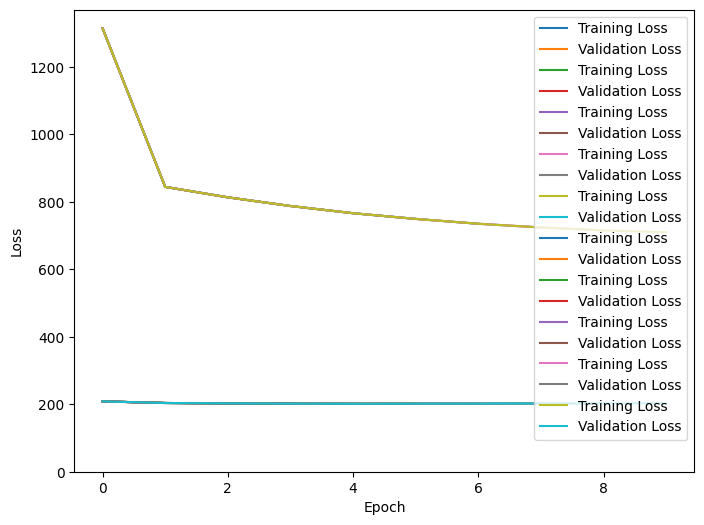

In [20]:
training_stats = []
all_training_loss=[]
all_valid_loss=[]
for epoch_i in range(num_epochs):
  print(f'Beginning epoch {epoch_i+1} of {num_epochs}')
  total_train_loss = 0
  model.train()

  # Labels are shifted by 1 timestep
  for step, batch in enumerate(train_dataloader):
    #input_ids (torch.LongTensor of shape (batch_size, input_ids_length)) — input_ids_length = sequence_length if past_key_values is None else past_key_values[0][0].shape[-2] (sequence_length of input past key value states). Indices of input sequence tokens in the vocabulary.

    #labels (torch.LongTensor of shape (batch_size, sequence_length), optional) — Labels for language modeling. Note that the labels are shifted inside the model, i.e. you can set labels = input_ids Indices are selected in [-100, 0, ..., config.vocab_size] All labels set to -100 are ignored (masked), the loss is only computed for labels in [0, ..., config.vocab_size]

    #attention_mask (torch.FloatTensor of shape (batch_size, sequence_length), optional) — Mask to avoid performing attention on padding token indices. Mask values selected in [0, 1]:
    #1 for tokens that are not masked,
    #0 for tokens that are masked.
    
    b_input_ids = batch[0].to(device)
    b_labels = batch[0].to(device)
    b_masks = batch[1].to(device)

    model.zero_grad()

    outputs = model(b_input_ids,
                    labels=b_labels,
                    attention_mask=b_masks)
    #loss: Cross Entropy loss is used by the model (torch.FloatTensor of shape (1,), optional, returned when labels is provided) — Language modeling loss (for next-token prediction).
    loss = outputs[0]

    batch_loss = loss.item()
    total_train_loss += batch_loss
    loss.backward()
    optimizer.step()
    scheduler.step()
    # log metrics to wandb
    wandb.log({"Training Loss": loss})

  all_training_loss.append(total_train_loss)
  avg_train_loss = total_train_loss / len(train_dataloader)
  print(f'Average Training Loss: {avg_train_loss}.')
  model.eval()

  total_eval_loss = 0
  nb_eval_steps = 0

  for batch in val_dataloader:
    b_input_ids = batch[0].to(device)
    b_labels = batch[0].to(device)
    b_masks = batch[1].to(device)
        
    with torch.no_grad():        

        outputs  = model(b_input_ids,  
                         attention_mask = b_masks,
                         labels=b_labels)
          
        loss = outputs[0]  
        wandb.log({"Validation Loss": loss})

    batch_loss = loss.item()
    total_eval_loss += batch_loss   

  all_valid_loss.append(total_eval_loss)
  avg_val_loss = total_eval_loss / len(val_dataloader)  
  print(f'Validation loss: {avg_val_loss}.')
  print()
  torch.save(model.state_dict(), f'gpt2_finetuned_epoch_{epoch_i}.pt')
  plt.plot(all_training_loss, label='Training Loss')
  plt.plot(all_valid_loss, label='Validation Loss')
  plt.ylim(bottom=0)
  plt.legend()
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  display.display(plt.gcf())
  display.clear_output(wait=True)
  # Record all statistics from this epoch.
  training_stats.append(
      {
          'epoch': epoch_i + 1,
          'Training Loss': avg_train_loss,
          'Valid. Loss': avg_val_loss,
      }
  )
wandb.finish()

In [23]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel,GPT2Config

# Load the fine-tuned GPT-2 model and tokenizer
model_path = "gpt2_finetuned_epoch_9.pt"
my_tokenizer = GPT2Tokenizer.from_pretrained('gpt2', 
                                          bos_token='<|startoftext|>', 
                                          eos_token='<|endoftext|>', 
                                          pad_token='<|pad|>')
model_state_dict = torch.load(model_path, map_location=torch.device(device))


# Create a new model and load the state dict
config = GPT2Config.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained('gpt2',config=config)
model.resize_token_embeddings(len(my_tokenizer))

model.load_state_dict(model_state_dict)


prompt = "Empower"

generated = torch.tensor(my_tokenizer.encode(prompt)).unsqueeze(0)
sample_outputs = model.generate(
                                generated, 
                                do_sample=True,   
                                top_k=50, 
                                max_length = 100,
                                top_p=0.95, 
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, my_tokenizer.decode(sample_output, skip_special_tokens=True)))

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: Empowering yourself with these habits can provide you with unlimited opportunities to pursue your passion.”


1: Empower is as vital to happiness as health.”


2: Empower is a quality. a commitment to greatness. a constant effort to sharpen your skills.”


